**Imported libraries**


In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error
import matplotlib.pyplot as plt
from google.colab import files
import io
from scipy.stats import pearsonr
import seaborn as sns
from tensorflow.keras.callbacks import EarlyStopping # 1. Import the EarlyStopping callback


**Connected to drive and uploaded datasets**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
train_file_path = '/content/drive/My Drive/IndoorLocalization/trainingData.csv'
validation_file_path = '/content/drive/My Drive/IndoorLocalization/validationData.csv'

In [4]:
train_df = pd.read_csv(train_file_path)
validation_df = pd.read_csv(validation_file_path)

**Visualization of a raw RSSI values**

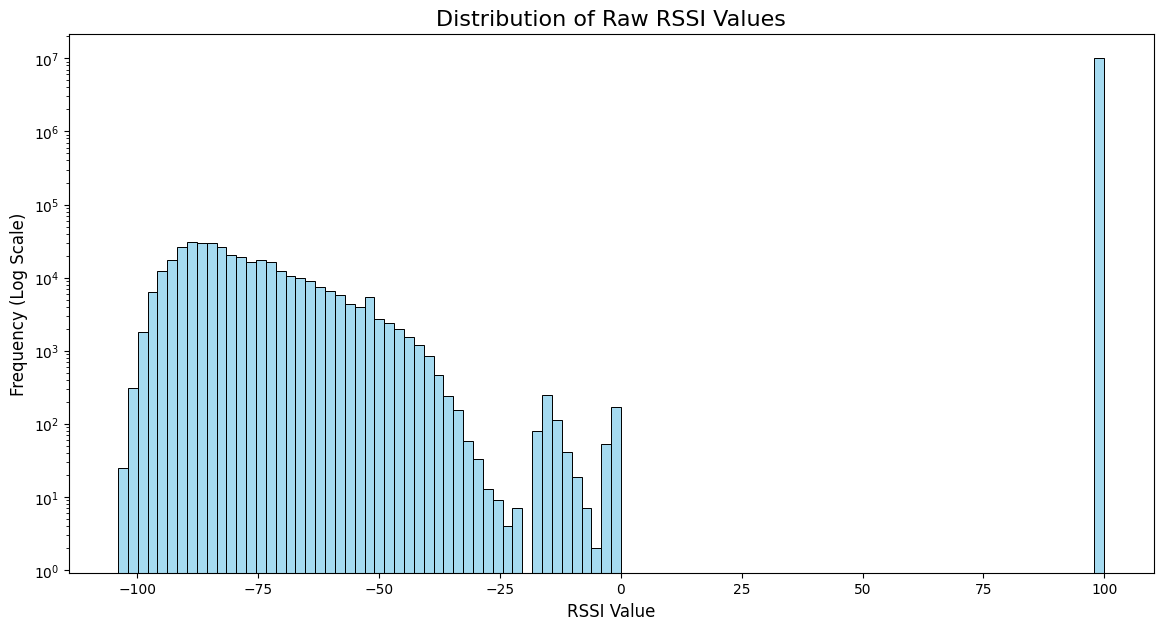

In [5]:
wap_features = train_df.iloc[:, 0:520] #train_df.iloc selects all rows and columns, but we want to select only columns starting from 0 until 520 (only WAP values). In dataset we have latitude and longitude and other columns. Created dataframe wap_features

plt.figure(figsize=(14, 7)) #created figure with size 14 inches wide and 7 inches tall
sns.histplot(wap_features.values.flatten(), bins=100, color='skyblue')#created histogram, flatten takes 2D grid of numbers from wap features values and makes one dimensional list. Bins divides all RSSI values into 100 equal sized bars. Each bar's height represents how many RSSI values in each bar
plt.title('Distribution of Raw RSSI Values', fontsize=16)
plt.xlabel('RSSI Value', fontsize=12)
plt.ylabel('Frequency (Log Scale)', fontsize=12)
plt.yscale('log') # Used a log scale to see the distribution of weaker signals better becaues 100 in the dataset a lot
plt.show() #shows the plot

**Data preprocessing**



In [6]:
NUM_FEATURES = 520 #created constant variable num_features for WAP values
IMAGE_DIM = 23 #created constant variable img_dim to reshape 520 features into a 2D image for CNN

X_train_raw = train_df.iloc[:, 0:NUM_FEATURES] #created dataframe with 520 WAP values for training
y_train_raw = train_df[['LONGITUDE', 'LATITUDE']] #created dataframe with only latitude and longitude columns. y_train_raw contains correct answers that we want to predict
X_test_raw = validation_df.iloc[:, 0:NUM_FEATURES] #created dataframe with 520 WAP values for testing, used validation dataset
y_test_raw = validation_df[['LONGITUDE', 'LATITUDE']] #created dataframe with only latitude and longitude columns for testing

# Cleaned RSSI values in train and test sets, replaced 100(not detected signal) with -105, inplace=True, modifies train and test datasets directly, without creating a new dataset
X_train_raw.replace(100, -105, inplace=True)
X_test_raw.replace(100, -105, inplace=True)


feature_scaler = MinMaxScaler() #scales all numeric features to a fixed range
X_train_scaled = feature_scaler.fit_transform(X_train_raw) # fit learns all parameters from training data and finds minimum and maximum value for each 520 features and transform scales all values between 0 and 1
X_test_scaled = feature_scaler.transform(X_test_raw) #test dataset only transforms from 0 to 1

print("\nData preprocessing complete.")


Data preprocessing complete.


**Feature engineering**

In [7]:
y_train_dist = np.sqrt(y_train_raw['LONGITUDE']**2 + y_train_raw['LATITUDE']**2) #stored all data of latitude and longtitude in y_train_dist, received overall distance by using formula sqrt(LONGITUDE² + LATITUDE²)

# Calculated Pearson Correlation for each WAP
correlation_coeffs = [] #empty python list
for i in range(NUM_FEATURES): #for loop
    # pearsonr returns (coefficient, p-value)
    corr, _ = pearsonr(X_train_raw.iloc[:, i], y_train_dist) #used pearsonr library to calculate Pearson coefficient between WAP signal values and distance calculated by formula sqrt(LONGITUDE² + LATITUDE²), pearsonr returns two values (coefficient and p-value) but we need only coefficinet so used _ to ignore second value
    correlation_coeffs.append(abs(corr)) #used abs as in the paper, we need only strength of the relationship

correlation_coeffs = np.array(correlation_coeffs) #converts python list of 520 scores into an array
correlation_coeffs = np.nan_to_num(correlation_coeffs) #if correlation coefficient is undefined, NaN value we replace it with 0
print("Calculated Pearson Correlation Coefficients for all WAPs.")

# Created enhanced features using Hadamard Product, multiplied correlation coefficient with scaled WAP values
X_train_enhanced = X_train_scaled * correlation_coeffs
X_test_enhanced = X_test_scaled * correlation_coeffs
print("Created enhanced features using Hadamard Product.")

def reshape_to_images(features, image_dim): #function reshapes 1D list of 520 features into a 2D image
    padded_features = np.pad(features, ((0, 0), (0, image_dim**2 - NUM_FEATURES)), 'constant') #adds padding, 23*23-520 = 9, adds 9 columns of padding after the last feature
    images = padded_features.reshape(-1, image_dim, image_dim, 1) #reshapes padded 1D list of 529 features into a 4D array, (number of samples, 23 pixels high, 23 pixels wide, grayscale image)
    return images #returns shaped images

#final image conversion on both raining and testing datasets, called function reshape_to_images took x_train and x_test enhansed values and created images
X_train_images = reshape_to_images(X_train_enhanced, IMAGE_DIM) #final image conversion on both raining and testing datasets
X_test_images = reshape_to_images(X_test_enhanced, IMAGE_DIM)
print(f"Reshaped enhanced features into {X_train_images.shape[0]} images of size {IMAGE_DIM}x{IMAGE_DIM}.")


/tmp/ipython-input-1270430927.py:7: ConstantInputWarning: An input array is constant; the correlation coefficient is not defined.
  corr, _ = pearsonr(X_train_raw.iloc[:, i], y_train_dist) #used pearsonr library to calculate Pearson coefficient between WAP signal values and distance calculated by formula sqrt(LONGITUDE² + LATITUDE²), pearsonr returns two values (coefficient and p-value) but we need only coefficinet so used _ to ignore second value


Calculated Pearson Correlation Coefficients for all WAPs.
Created enhanced features using Hadamard Product.
Reshaped enhanced features into 19937 images of size 23x23.


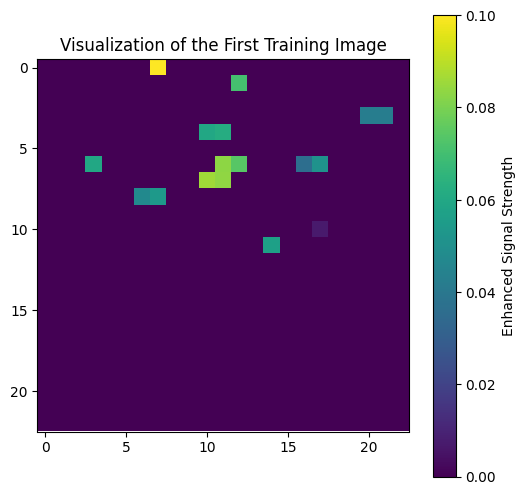

In [8]:
first_image = X_train_images[10] #selects very first image from dataset
plt.figure(figsize=(6, 6)) #creates figure with size 6 inches wide and 6 inches tall
plt.imshow(np.squeeze(first_image), cmap='viridis') # simplifies 3D into 2D grid and uses viridis colormap to color each pixel based on its signal stength
plt.title("Visualization of the First Training Image")
plt.colorbar(label="Enhanced Signal Strength") #adds colorbar
plt.show()

**k-NN (baseline)**

In [9]:
# Scaled y train and test for k-NN and CNN
label_scaler = MinMaxScaler() #scales all numeric features to a fixed range
y_train_scaled = label_scaler.fit_transform(y_train_raw) # fit learns all parameters from training data and finds minimum and maximum value for each latitude and longitude and transform scales all values between 0 and 1
y_test_scaled = label_scaler.transform(y_test_raw) #test dataset only transforms from 0 to 1

knn = KNeighborsRegressor(n_neighbors=5) #knn with 5 neighbors
knn.fit(X_train_scaled, y_train_scaled) #training knn
y_pred_knn_scaled = knn.predict(X_test_scaled) #model makes prediction on the x_test_scaled data
y_pred_knn = label_scaler.inverse_transform(y_pred_knn_scaled) #transforms 0 to 1 values into coordinates (longitude and latitude)
y_test_orig = label_scaler.inverse_transform(y_test_scaled) #transforms scaled true coordinates back to their original coordinate scale


**Evaluation function**

In [10]:
def evaluate_regression(model_name, y_true, y_pred): #evaluate regression function
    mae = mean_absolute_error(y_true, y_pred) #calculated mean absolute error with a pre-built finction from the sckitit-learn library
    rmse = np.sqrt(mean_squared_error(y_true, y_pred)) #first calculates the average of the suared differences then takes the square root of that result
    euclidean_distances = np.sqrt(np.sum((y_true - y_pred)**2, axis=1)) #first calculates the difference in both the latitude and longtitude for each point, then squares those differences. After that adds the squared longitude and the squared latitude difference together for each point, finally thakes the square root
    mean_euclidean_error = np.mean(euclidean_distances) #finds average of euclidean distances

#4f shows for decimal places
    print(f"\nResults for {model_name}:")
    print(f"  Mean Euclidean Distance Error: {mean_euclidean_error:.4f} meters (approx)")
    print(f"  Mean Absolute Error (MAE): {mae:.4f}")
    print(f"  Root Mean Squared Error (RMSE): {rmse:.4f}")
    return mean_euclidean_error #stores mean_euclidean_error values for later use

knn_error = evaluate_regression("k-NN Regressor", y_test_orig, y_pred_knn) #calles function and printed results of knn's mean euclidean distance error, mae, rmse


Results for k-NN Regressor:
  Mean Euclidean Distance Error: 9.7359 meters (approx)
  Mean Absolute Error (MAE): 6.2763
  Root Mean Squared Error (RMSE): 13.0361


**2D Convolutional Neural Network**

In [11]:
def build_cnn_model(input_shape): #function build_cnn_model
    model = Sequential([  #Keras sequential model
        Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=input_shape), #2D convolutional layer, scans the input images to find basic patterns, 32 number of filter, it looks 3x3 pixel area at a time. used Rectified Linear Unit activation function.
        MaxPooling2D(pool_size=(2, 2)), #max pooling, calculates the maximum value for each patch of the feature map
        Dropout(0.25), #randomly turns off 25% of the neurons in the previous layer for each update to prevent overfitting

        Conv2D(64, kernel_size=(3, 3), activation='relu'), #second conv layer, number of filters 64
        MaxPooling2D(pool_size=(2, 2)),
        Dropout(0.25),

        Flatten(), #flattens into a single, long, one-dimensional vector.

        Dense(128, activation='relu'), #dense layer with 128 neurons
        Dropout(0.5),

        Dense(2, activation='linear') #two neurons for latitude and longitude, linear activation to receive real numbers as a output, takes the flattened vector of features and transforms into the final output
    ])

    model.compile(optimizer='adam', loss='mean_squared_error') #adam optimization algorithm to control model's internal weights during training updates, loss mean squared error
    return model

cnn_model = build_cnn_model((IMAGE_DIM, IMAGE_DIM, 1)) #calls function build_cnn_model, creates cnn model
cnn_model.summary() #prints summary of the model's architecture, showing all layers, output shaper


early_stopping_callback = EarlyStopping( #EarlyStopping
    monitor='val_loss', #monitor the validation loss
    patience=10, #training will stop if validation loss doesn't improve for 10 consecutive epochs
    verbose=1,
    restore_best_weights=True #ensures the model uses the weights from the best epoch, not the last one
)

history = cnn_model.fit(
    X_train_images, #train input images
    y_train_scaled, #correct scaled answers
    epochs=50, #goes through entire traing dataset 200 times
    batch_size=64, #model looks at 64 samples at a time before updating its internal weights
    validation_split=0.1, #10% of the training data used as a validation set
    verbose=1, #prints progress bar during training
    callbacks=[early_stopping_callback] # 3. Add the callback to the fit method
)

y_pred_cnn_scaled = cnn_model.predict(X_test_images) #uses fully trained model to make predictions on the unseen test images. The predictions scaled from 0 to 1
y_pred_cnn = label_scaler.inverse_transform(y_pred_cnn_scaled) #converts scaled predictions back into real-world longitude and latitude coordinates

cnn_error = evaluate_regression("CNN on Enhanced Images", y_test_orig, y_pred_cnn) #calculates metrics of cnn model by comparing predictions to the true answers


/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 21, 21, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 10, 10, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 8, 8, 64)       │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 4, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       131,200 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 2)              │           258 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 150,274 (587.01 KB)

 Trainable params: 150,274 (587.01 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 16s 44ms/step - loss: 0.0776 - val_loss: 0.0092
Epoch 2/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 19s 40ms/step - loss: 0.0176 - val_loss: 0.0068
Epoch 3/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 40ms/step - loss: 0.0139 - val_loss: 0.0070
Epoch 4/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0121 - val_loss: 0.0045
Epoch 5/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 11s 37ms/step - loss: 0.0104 - val_loss: 0.0056
Epoch 6/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 21s 40ms/step - loss: 0.0095 - val_loss: 0.0041
Epoch 7/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 35ms/step - loss: 0.0082 - val_loss: 0.0033
Epoch 8/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 12s 40ms/step - loss: 0.0076 - val_loss: 0.0030
Epoch 9/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - loss: 0.0072 - val_loss: 0.0029
Epoch 10/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0069 - val_loss: 0.0029
Epoch 11/50
281/281 ━━━━━━━━━━━━━━━━━━━━ 10s 36ms/step - loss: 0.0064 - val_loss: 0.0027
Epoch 12/50
281/281 ━━━━━━━━━━

**Visualization**

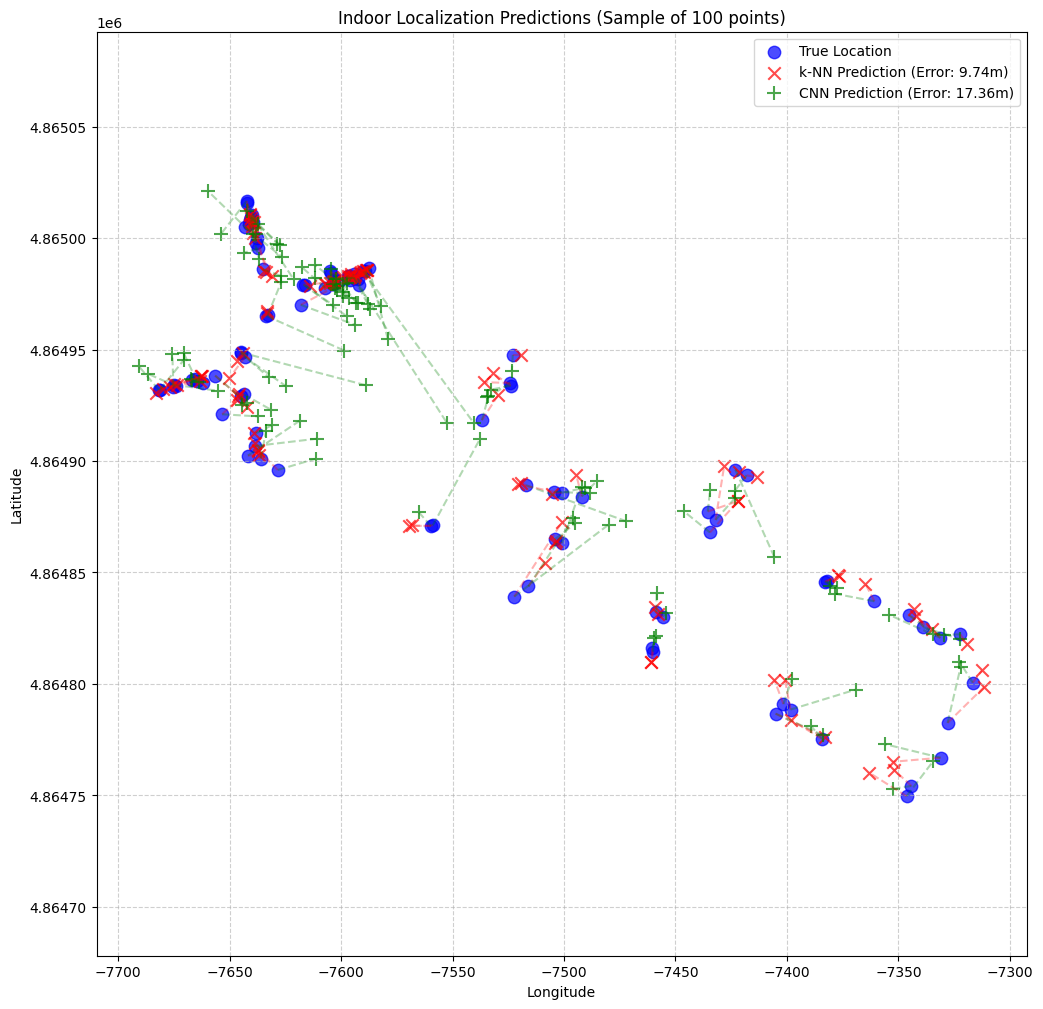

In [12]:
num_samples_viz = 100 #visualized only 100 samples
indices = np.random.choice(len(y_test_orig), num_samples_viz, replace=False) #chose random 100 samples, ensured to not pick the same value more than once, and all values picked randomly from all over the building

plt.figure(figsize=(12, 12)) # figure size 12х12
plt.scatter(y_test_orig[indices, 0], y_test_orig[indices, 1], c='blue', label='True Location', alpha=0.7, s=80) #created scatter plot with true longitude and latitude values, they are blue points
plt.scatter(y_pred_knn[indices, 0], y_pred_knn[indices, 1], c='red', label=f'k-NN Prediction (Error: {knn_error:.2f}m)', marker='x', alpha=0.7, s=80) #draw predicted values of knn, they are red x points
plt.scatter(y_pred_cnn[indices, 0], y_pred_cnn[indices, 1], c='green', label=f'CNN Prediction (Error: {cnn_error:.2f}m)', marker='+', alpha=0.7, s=100)#draw predicted values of cnn, they are green + points


#draw dashed lines for the k-nn and cnn errors, connected the true points to their predictions with dashed lines,
for i in indices:
    plt.plot([y_test_orig[i, 0], y_pred_knn[i, 0]], [y_test_orig[i, 1], y_pred_knn[i, 1]], 'r--', alpha=0.3)
    plt.plot([y_test_orig[i, 0], y_pred_cnn[i, 0]], [y_test_orig[i, 1], y_pred_cnn[i, 1]], 'g--', alpha=0.3)

plt.title(f'Indoor Localization Predictions (Sample of {num_samples_viz} points)')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.6) #added background grid
plt.axis('equal') #ensures x-axis and y-axis are the same
plt.show()
